In [1]:
#Assignment 2 Data Mining

In [1]:
import numpy as np
import pandas as pd
import h5py
import random
import csv 
from tabulate import tabulate
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,r2_score,matthews_corrcoef
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,precision_recall_curve, average_precision_score
from keras import layers
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.tensorflow_backend._get_available_gpus()
K.set_image_data_format('channels_last')
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import imshow
from skimage.color import rgb2hed
from joblib import Parallel, delayed
import multiprocessing
import concurrent.futures
import time

Using TensorFlow backend.


In [2]:
#Path of the folder that I am going to use
filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/breast.h5"

#File that contains all the datasets we are going to use
D = h5py.File(filepath, 'r')
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

P.shape=[P.shape[0],1]
Y.shape=[Y.shape[0],1]

In [4]:
print('Question 1.i)')
print('')
N_Img=P.shape[0]

#Count the number IDs which value is less than 13 and bigger than 13
n_train=sum(i <= 13 for i in P)
n_train=n_train[0]
n_test=sum(i > 13 for i in P)
n_test=n_test[0]

print('Shape of the image data set:',X.shape)
print('Total number of images:',N_Img)
print('Total number training examples (IDs 1-13):',n_train,',',"{:.2%}".format(n_train/N_Img))
print('Total number test examples (IDs 14-18):',n_test,',',"{:.2%}".format(n_test/N_Img))

Question 1.i)

Shape of the image data set: (7404, 299, 299, 3)
Total number of images: 7404
Total number training examples (IDs 1-13): 5841 , 78.89%
Total number test examples (IDs 14-18): 1563 , 21.11%


Question 1.ii)

Sample: 1
Patient IDs: [8]
Cell Counts: [1]
Image: 2315

Sample: 2
Patient IDs: [8]
Cell Counts: [6]
Image: 2390

Sample: 3
Patient IDs: [10]
Cell Counts: [1]
Image: 3366

Sample: 4
Patient IDs: [11]
Cell Counts: [3]
Image: 3965

Sample: 5
Patient IDs: [18]
Cell Counts: [1]
Image: 7079

By observing the images and comparing them with the values that the corresponding Y value(Cell counts), the brown/black
cells that are observed in the image is equal to the value of the Y variable. In some cases is difficult to tell if the
cell count should be more or less depending on the image.


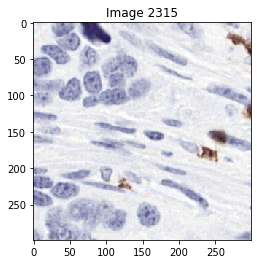

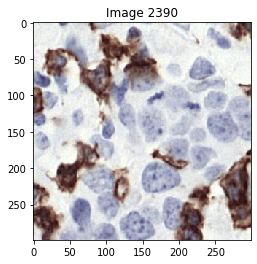

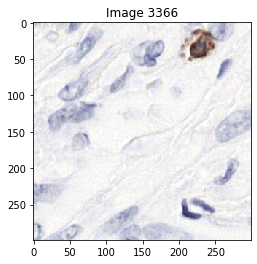

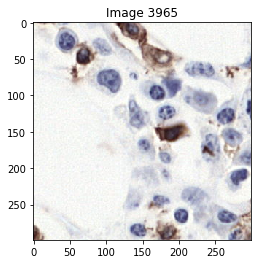

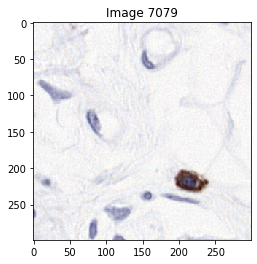

In [5]:
print('Question 1.ii)')
print('')
#Number of images that we want to print
sample= 5
sample_rgb=np.random.randint(0,N_Img-1,sample)
sample_rgb=np.sort(sample_rgb)

#Generate the image given the random number
for i in range(sample):
    #Select a random imagre from all the set
    rnd_idx = sample_rgb[i]
    
    #Plot and print the information of each image
    print('Sample:',i+1)
    plt.figure()
    Image=plt.imshow(X[rnd_idx])
    plt.title("Image " +str(sample_rgb[i]))
    print('Patient IDs:',P[rnd_idx])
    print('Cell Counts:',Y[rnd_idx])
    print('Image:',rnd_idx)
    print('')

print('By observing the images and comparing them with the values that the corresponding Y value(Cell counts), the brown/black')
print('cells that are observed in the image is equal to the value of the Y variable. In some cases is difficult to tell if the')
print('cell count should be more or less depending on the image.')

Question 1.iii)

Lymphocytes count per bin:
----  ----  ----  -----  -----  ------  ----
   0  1-5   6-10  11-20  21-50  51-200  >200
1397  4811  736   356    103    1       0
----  ----  ----  -----  -----  ------  ----


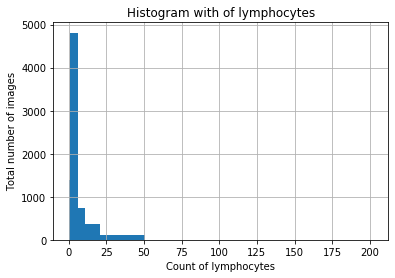

In [6]:
print('Question 1.iii)')
print('')
#Histogram with all lymphocytes 
plt.figure()
plt.hist(Y, bins=[0,1,6,11,21,51,201,202]);plt.grid();plt.title("Histogram with of lymphocytes");plt.xlabel('Count of lymphocytes');plt.ylabel('Total number of images')

hist_lymphocytes=np.histogram(Y,bins=[0,1,6,11,21,51,201,202])
p1=["0","1-5","6-10","11-20","21-50","51-200",">200"]
p2=hist_lymphocytes[0]
table=[p1,p2]
print("Lymphocytes count per bin:")
print(tabulate(table))

Question 1.iv)

Sample images:
[2315 2390 3366 3965 7079]


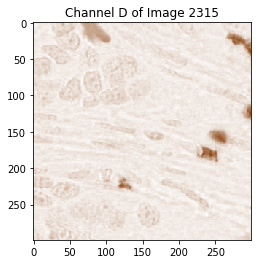

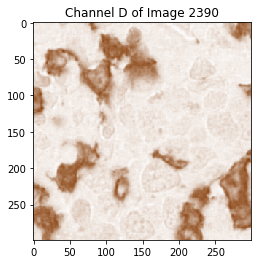

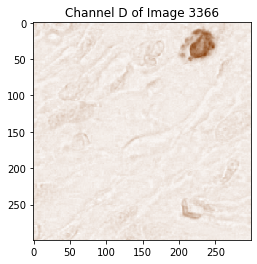

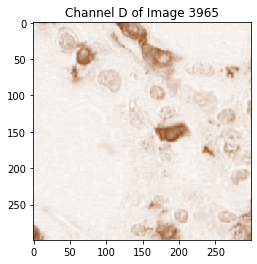

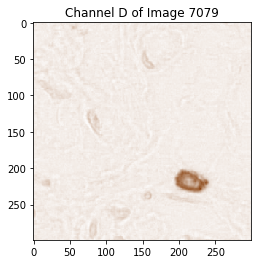

In [6]:
print('Question 1.iv)')
print('')

sample_hed=sample_rgb
sample_hed=np.sort(sample_hed)
print('Sample images:')
print(sample_hed)

#Create an artificial color close to the original one
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])

#Print of the images with new color format (only D channel)
for i in range(sample):
    
    ihc_rgb =X[sample_hed]
    ihc_hed = rgb2hed(ihc_rgb)
    
    plt.figure()
    plt.imshow(ihc_hed[i,:, :, 2], cmap=cmap_dab)
    plt.title("Channel D of Image " +str(sample_hed[i]))

Question 1.v)



Text(0, 0.5, 'Cell Count')

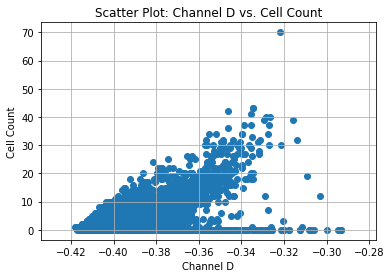

In [83]:
print('Question 1.v)')
print('')

hed_channel_D_mean=np.empty([N_Img, 1])

#Calculate the mean of each image given de HED color format
for i in range(X.shape[0]):
    X_hed = rgb2hed(X[i])
    hed_channel_D_mean[i]=np.mean(X_hed[:, :, 2])

#Scatter plot 
plt.scatter(hed_channel_D_mean,Y);plt.grid();plt.title("Scatter Plot: Channel D vs. Cell Count");plt.xlabel('Channel D');plt.ylabel('Cell Count')

###### In general, it can be seen that there is  positive relation between the average of the brown channel with the total number of cell count.This means that the bigger the mean the bigger the cell count will be. In terms of the regression, the mean could be a signigicant variable to add to the model because of the fact explained above. In addition, there are many images with zero cell count (18% of all the images) that may generate an inbalance train and test set. 

Question 1.vi)

Patient 1 has 320 images.
Patient 2 has 465 images.
Patient 3 has 958 images.
Patient 4 has 192 images.
Patient 5 has 44 images.
Patient 6 has 105 images.
Patient 7 has 83 images.
Patient 8 has 632 images.
Patient 9 has 533 images.
Patient 10 has 552 images.
Patient 11 has 761 images.
Patient 12 has 791 images.
Patient 13 has 405 images.
Patient 14 has 105 images.
Patient 15 has 399 images.
Patient 16 has 604 images.
Patient 17 has 103 images.
Patient 18 has 352 images.


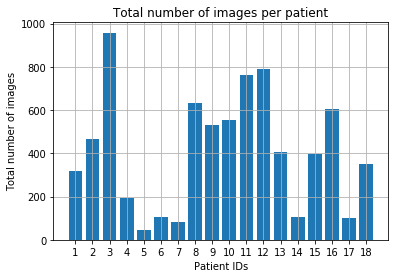

In [7]:
print('Question 1.vi)')
print('')

#Unique count of images for each patient
P_unique, P_counts = np.unique(P, return_counts=True)
P_summary=np.stack((P_unique, P_counts),axis=-1)

Y_unique, Y_counts = np.unique(Y, return_counts=True)
Y_summary=np.stack((Y_unique, Y_counts),axis=-1)

#Chart of the images per patient
objects = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18')
plt.bar(P_unique,P_counts, width=0.8, align='center', alpha=1);plt.xticks(P_unique, objects);plt.grid();plt.title("Total number of images per patient");plt.xlabel('Patient IDs');plt.ylabel('Total number of images')

#Print of total images per patient
for i in range(18):
    print('Patient', i+1, 'has', P_counts[i], 'images.')

#### Yes. Some patients have much more images than other patients, this means that when splitting the data into train and test set, we could observe more concentration of one particular patient; thus biasing the results of the model. If all the images where independent of each other we would not have this problem.

In [13]:
print('Question 1.vii)')
print('')

Question 1.vii)



#### Since we are doing a regression model, the best performance metric that can we use is the mean squared error (MSE) and  the coeficient of determination (R^2). In our model, we will try to minimize the MSE which is the average of the square of the errors. This means that if we achieved to get a value of 0 for the MSE, we will have a perfect fit. On the other hand, the R^2 will help us explain the proportion of the variance in the dependent variable (cell count) that the independent variables (features) explain all together. The bigger the value, the better. Nevertheless, big values of the R^2, near to 1, will lead to multicoliniality problems.

Question 2.i)

a), b) and c) of image 7079:
Variable          Red      Green      Blue         Brown
----------  ---------  ---------  --------  ------------
Mean        235.627    234.723    237.508   -0.412611
Variance    518.041    595.781    452.659    0.000153876
Entropy       5.36235    5.31493    5.1088  10.3462

d)


Text(0, 0.5, 'Frecuency')

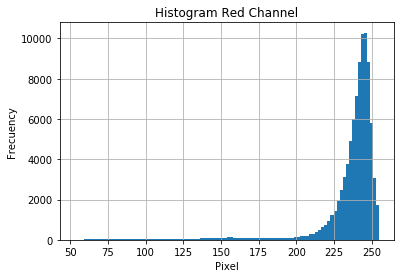

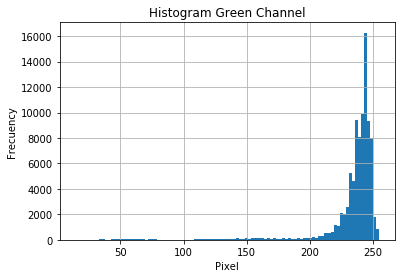

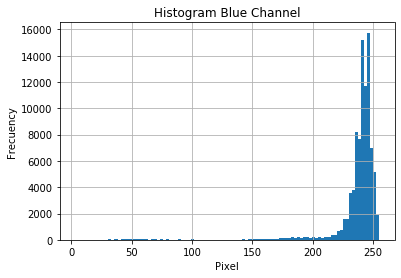

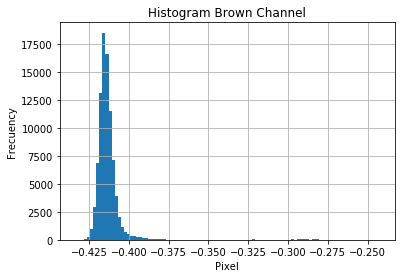

In [7]:
print('Question 2.i)')
print('')

#Select one image from previous images used
image = np.random.choice(sample_rgb,1) 
image=image[0]
id=image
image=X[image]

#a,b,c)Mean, variance and entropy of the “brown”, red, green and blue channels 
image_hed = rgb2hed(image)

#Calculate the mean of the brown and RGB channels
average_brown = np.mean(image_hed[:,:,2])
average_colors=np.mean(image, axis=(0,1))
average_colors=np.append(average_colors,average_brown)
mean_colors=np.append("Mean",average_colors)

#Calculate the variance of the brown and RGB channels
var_brown = np.var(image_hed[:,:,2])
var_colors=np.var(image, axis=(0,1))
var_colors=np.append(var_colors,var_brown)
variance_colors=np.append("Variance",var_colors)

#Calculate the entropy of the brown and RGB channels   
ent_colors=np.empty(4)   
ent_colors[0]= skimage.measure.shannon_entropy(image[:,:,0])
ent_colors[1]= skimage.measure.shannon_entropy(image[:,:,1])
ent_colors[2]= skimage.measure.shannon_entropy(image[:,:,2])
ent_colors[3]= skimage.measure.shannon_entropy(image_hed[:,:,2])
entropy_colors=np.append("Entropy",ent_colors)  

#Generate a table with all results
table=[mean_colors,variance_colors,entropy_colors]
print('a), b) and c) of image ' +str(id)+':')
print(tabulate(table, headers=["Variable","Red","Green","Blue","Brown"]))
    
#d)Histogram of each channel
red_reshape=np.reshape(image[:,:,0],image.shape[0]*image.shape[1])
green_reshape=np.reshape(image[:,:,1],image.shape[0]*image.shape[1])
blue_reshape=np.reshape(image[:,:,2],image.shape[0]*image.shape[1])
brown_reshape=np.reshape(image_hed[:,:,2],image_hed.shape[0]*image_hed.shape[1])

print('')
print('d)')
plt.figure()
plt.hist(red_reshape, bins=100);plt.grid();plt.title("Histogram Red Channel");plt.xlabel("Pixel");plt.ylabel("Frecuency")
         
plt.figure()
plt.hist(green_reshape, bins=100);plt.grid();plt.title("Histogram Green Channel");plt.xlabel("Pixel");plt.ylabel("Frecuency")
         
plt.figure()
plt.hist(blue_reshape, bins=100);plt.grid();plt.title("Histogram Blue Channel");plt.xlabel("Pixel");plt.ylabel("Frecuency")
         
plt.figure()
plt.hist(brown_reshape, bins=100);plt.grid();plt.title("Histogram Brown Channel");plt.xlabel("Pixel");plt.ylabel("Frecuency")


e)
Time elapsed to run PCA: 164.43 seconds
Variance explained by 200 components: 0.8271552788539089
Shape of original images: (283, 283)
Shape of PCA images: (283, 283)

Sample of Images:


Text(0.5, 1.0, 'PCA Image 3366')

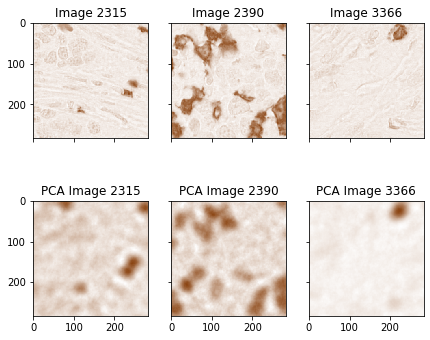

In [8]:
#Function that turns batches of images into the color format HED
def process_D_channel(X,list_N_Img,pixel):
        from skimage.color import rgb2hed
        X_hed = rgb2hed(X[list_N_Img])
        list_X_hed=list(range(0,X_hed.shape[0]))
        #pixels reduction given in the instructions of the competition
        images_channel_D=X_hed[list_X_hed,pixel:(X_hed.shape[1]-pixel),pixel:(X_hed.shape[2]-pixel),2]
        results=images_channel_D
        return results

N_Img=P.shape[0]

#Batches 
list_N_Img_1=list(range(0,1500))
list_N_Img_2=list(range(1500,3000))
list_N_Img_3=list(range(3000,4500))
list_N_Img_4=list(range(4500,6000))
list_N_Img_5=list(range(6000,N_Img))
t=1
pixel=8
results=np.empty([N_Img,299-pixel,299-pixel])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])

t1=time.perf_counter()
res_1=process_D_channel(X,list_N_Img_1,pixel)
time.sleep(t)

res_2=process_D_channel(X,list_N_Img_2,pixel)
time.sleep(t)

res_3=process_D_channel(X,list_N_Img_3,pixel)
time.sleep(t)

res_4=process_D_channel(X,list_N_Img_4,pixel)
time.sleep(t)

res_5=process_D_channel(X,list_N_Img_5,pixel)
time.sleep(t)

#Concatenation of all batches
results=np.concatenate((res_1,res_2,res_3,res_4,res_5),axis=0)
del (res_1,res_2,res_3,res_4,res_5)

#Transformation of the variable results so it can be in 2-D and can be used to PCA
image_rs=np.reshape(results,(results.shape[0],results.shape[1]*results.shape[2]))

#Number of PCA proposed and PCA method(Incremental PCA)
n_components = 200
ipca = IncrementalPCA(n_components=n_components, batch_size=1000)
image_ipca = ipca.fit_transform(image_rs)
image_ipca_transform=ipca.inverse_transform(image_ipca)
print('')
print('e)')
t2=time.perf_counter()
#Creation of the real image vs. the PCA image
print('Time elapsed to run PCA:',round(t2-t1,2),'seconds')
print('Variance explained by',n_components,'components:',np.sum(ipca.explained_variance_ratio_))
print('Shape of original images:',np.reshape(image_rs[sample_hed[0],:],(283,283)).shape)
print('Shape of PCA images:',np.reshape(image_ipca_transform[sample_hed[0],:],(283,283)).shape)

print('')
print('Sample of Images:')
fig, axes = plt.subplots(2, 3, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(np.reshape(image_rs[sample_hed[0],:],(283,283)),cmap=cmap_dab)
ax[0].set_title("Image " +str(sample_hed[0]))

ax[1].imshow(np.reshape(image_rs[sample_hed[1],:],(283,283)),cmap=cmap_dab)
ax[1].set_title("Image " +str(sample_hed[1]))

ax[2].imshow(np.reshape(image_rs[sample_hed[2],:],(283,283)),cmap=cmap_dab)
ax[2].set_title("Image " +str(sample_hed[2]))

ax[3].imshow(np.reshape(image_ipca_transform[sample_hed[0],:],(283,283)),cmap=cmap_dab)
ax[3].set_title("PCA Image " +str(sample_hed[0]))

ax[4].imshow(np.reshape(image_ipca_transform[sample_hed[1],:],(283,283)),cmap=cmap_dab)
ax[4].set_title("PCA Image " +str(sample_hed[1]))

ax[5].imshow(np.reshape(image_ipca_transform[sample_hed[2],:],(283,283)),cmap=cmap_dab)
ax[5].set_title("PCA Image " +str(sample_hed[2]))

In [14]:
print('')
print('f)')


f)


#### The mean and the variance. With the results of the scatter plot in question 1.v) it can be seen that there is a difference between images with more concentration of brown color that the ones that does not have. Since concentration of color results in different mean and variance, it will be a good idea to consider them as variables for the regression model. It is worth mentioning that the images with less than 5 cell count will have an impact in the model, since they represent 83% of all the sample.

Scatter plots of PCAs vs. Cell Count:


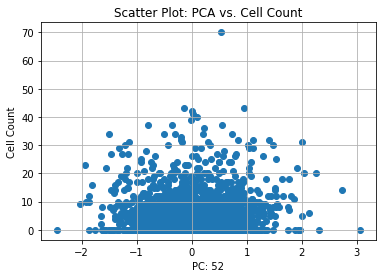

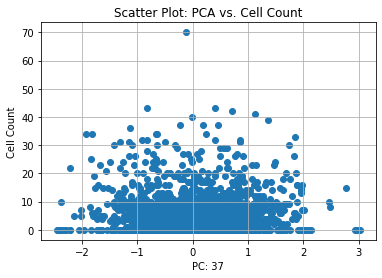

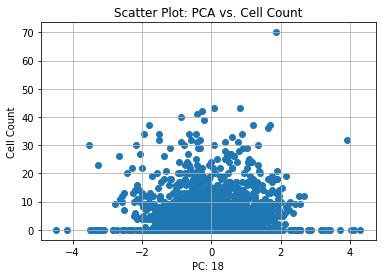

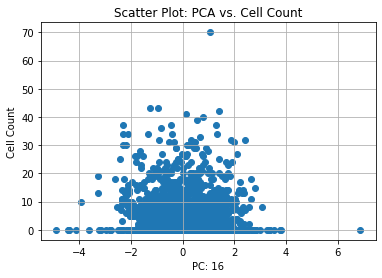

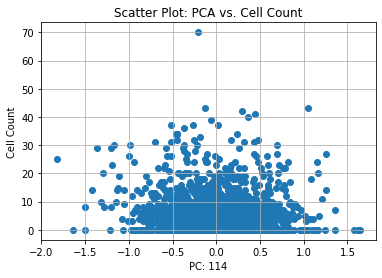

In [4]:
filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/" 

#Call the h5 file from the folder that is saved
datasets_ipca = h5py.File(filepath+str('datasets_ipca.h5'), 'r')

#Create h5df from each dataset that is inside the h5 file
image_ipca=datasets_ipca.get('image_ipca')

#Convert the variable in h5 format into numpy
image_ipca=np.array(image_ipca)

## Split the PCA data and the Y into train and test sets
idtrain=[i for i, P in enumerate(P) if P <=13]
idtest=[i for i, P in enumerate(P) if P >13]

image_ipca_train=image_ipca[idtrain]
image_ipca_test=image_ipca[idtest]
Y_train=Y[idtrain] 
Y_train=np.reshape(Y_train,(Y_train.shape[0],1))
Y_test=Y[idtest] 
Y_test=np.reshape(Y_test,(Y_test.shape[0],1))

#Scatter plots of some PCAs obtained with the cell count
print('Scatter plots of PCAs vs. Cell Count:')
for i in range(5):   
    rand=random.randint(0,image_ipca_train.shape[1])
    plt.figure()
    plt.scatter(image_ipca_train[:,rand],Y_train);plt.grid();plt.title("Scatter Plot: PCA vs. Cell Count");plt.xlabel("PC: " +str(rand));plt.ylabel("Cell Count")

In [5]:
filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/"
hed_channel_D_mean = pd.read_csv(filepath+str('hed_channel_D_mean.csv'),header = None)
hed_channel_D_mean=hed_channel_D_mean.to_numpy()

#Calculation of the correlation coefficient
corrcoef=np.corrcoef(hed_channel_D_mean,Y,rowvar=False)[0,1]
print('Correlation Coeficient:',np.round(corrcoef,3))

Correlation Coeficient: 0.593


In [4]:
print('Question 2.ii)')
print('')

filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/" 

#Call the h5 file from the folder that is saved
datasets_ipca = h5py.File(filepath+str('datasets_ipca.h5'), 'r')

#Create h5df from each dataset that is inside the h5 file
image_ipca=datasets_ipca.get('image_ipca')

#Convert the variable in h5 format into numpy
image_ipca=np.array(image_ipca)

## Split the PCA data and the Y into train and test sets
idtrain=[i for i, P in enumerate(P) if P <=13]
idtest=[i for i, P in enumerate(P) if P >13]

image_ipca=np.array(image_ipca)
image_ipca_train=image_ipca[idtrain]
image_ipca_test=image_ipca[idtest]
Y_train=Y[idtrain] 
Y_train=np.reshape(Y_train,(Y_train.shape[0],1))
Y_test=Y[idtest] 
Y_test=np.reshape(Y_test,(Y_test.shape[0],1))

print('a) Linear Regression')
ols = LinearRegression()

#Hyperparameter space
hyperparameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

clf = GridSearchCV(ols, hyperparameters, cv=3, n_jobs=-1, verbose=0)
best_clf = clf.fit(image_ipca_train, Y_train.ravel())

#Optimal parameters
fit_intercept=best_clf.best_estimator_.get_params()['fit_intercept']
normalize=best_clf.best_estimator_.get_params()['normalize']
copy_X=best_clf.best_estimator_.get_params()['copy_X']

#Dictonary of all tuned hyperparameters
tune_hyper_lr=best_clf.best_params_
print('Best hyperparameters:')
print(tune_hyper_lr) 
print('')

#Optimal score given the optimal parameters
best_score=best_clf.best_score_
print('Best Score:')
print(best_score)  
print('')

#OLS method with CV a feature selection. Every method has the same structure
def ols_reg(fit_intercept,normalize,copy_X,image_ipca_train,Y_train):
    results=()
    #Number of folds
    skf = StratifiedKFold(n_splits=3,random_state=1,shuffle = True)
    A=[]
    B=np.empty([image_ipca_train.shape[1], 1])
    C=[]
      
    for i, (train_index, test_index) in enumerate(skf.split(image_ipca_train, Y_train)):
        Xcv_train, Xcv_test = image_ipca_train[train_index], image_ipca_train[test_index]
        Ycv_train, Ycv_test = Y_train[train_index], Y_train[test_index]
        
        #Hyperparameter object for linear regression
        clf = LinearRegression(fit_intercept=fit_intercept,normalize=normalize,copy_X=copy_X)
        
        #Feature selection given the object of hyperparameters
        red_param=RFECV(clf, step=1, cv=3)
        
        #Training of the model given the best parameters
        red_param.fit(Xcv_train,Ycv_train.ravel())
        
        Y_pred=red_param.predict(Xcv_test)
        r2=r2_score(Ycv_test,Y_pred.ravel())
        A.append(r2)
                
        mse=np.sqrt(mean_squared_error(Ycv_test,Y_pred.ravel()))
        C.append(mse)
    
    #Calculation of all correlation coeficients for each PCA feature (200)
    for i in range(image_ipca_train.shape[1]):
        B[i,0]=np.corrcoef(image_ipca_train[:,i],Y_train,rowvar=False)[0,1]
        
    results=np.around([np.mean(A),np.std(A),np.mean(B),np.std(B),np.mean(C),np.std(C)],decimals=3)
    return(results)

results_ols_reg=ols_reg(fit_intercept,normalize,copy_X,image_ipca_train,Y_train)

table=[results_ols_reg]

print('Linear Regresion results:')
print(tabulate(table, headers=["Mean R^2","Std. R^2","Mean Corr.Coef.","Std. Corr.Coef.","Mean RMSE","Std. RMSE"]))
print('')
print('Summary of the table:')
print('It can be seen from the previous table, that a linear model explain little variation with respect the response variable. Proof of this can also be seen in the scatter plots of the PCAs vs. Cell Count.')
print('This results suggest that we should not consider linear models as a model of choise to predict de cell count. ')

Question 2.ii)

a) Linear Regression
Best hyperparameters:
{'copy_X': True, 'fit_intercept': True, 'normalize': False}

Best Score:
0.18363323807566134



C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Linear Regresion results:
  Mean R^2    Std. R^2    Mean Corr.Coef.    Std. Corr.Coef.    Mean RMSE    Std. RMSE
----------  ----------  -----------------  -----------------  -----------  -----------
      0.25       0.039              0.005              0.043        3.944        0.152

Summary of the table:
It can be seen from the previous table, that a linear model explain little variation with respect the response variable. Proof of this can also be seen in the scatter plots of the PCAs vs. Cell Count.
This results suggest that we should not consider linear models as a model of choise to predict de cell count. 


Question 2.ii)

b) Multilayer Perceptron

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7799544727826046040
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6614766059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10353823649211197140
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 80,601
Trainable params: 80,601
Non-trainable params: 0
_________________________________________________________________
None
Train on 3948 samples, validate on 988 samples
Epoch 1/20
3948/3948 [==============================] - 1s 201us/step - loss: 17.9760 - val_loss: 11.9015
Epoch 2/20
3948/3948 [==============================] - 0s 48us/step - loss: 12.9537 - val_loss: 13.0058
Epoch 3/20
3948/3948 [==============================] - 0s 52us/step - loss: 11.2344 - val_loss: 11.5748
Epoch 4/20
3

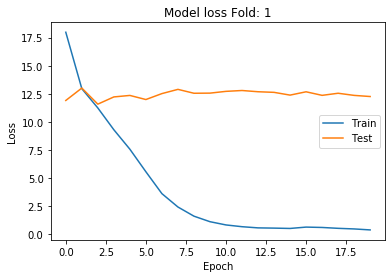

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 80,601
Trainable params: 80,601
Non-trainable params: 0
_________________________________________________________________
None
Train on 3948 samples, validate on 988 samples
Epoch 1/20
3948/3948 [==============================] - 0s 70us/step - loss: 18.8322 - val_loss: 12.5231
Epoch 2/20
3948/3948 [==============================] - 0s 48us/step - loss: 13.3183 - val_loss: 12.6186
Epoch 3/20
3948/3948 [==============================] - 0s 49us/step - loss: 11.6099 - val_loss: 12.9687
Epoch 4/20
39

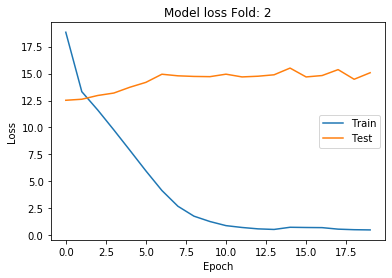

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 80,601
Trainable params: 80,601
Non-trainable params: 0
_________________________________________________________________
None
Train on 3948 samples, validate on 988 samples
Epoch 1/20
3948/3948 [==============================] - 0s 71us/step - loss: 16.5636 - val_loss: 15.2980
Epoch 2/20
3948/3948 [==============================] - 0s 49us/step - loss: 11.9102 - val_loss: 14.6139
Epoch 3/20
3948/3948 [==============================] - 0s 48us/step - loss: 10.1301 - val_loss: 14.3262
Epoch 4/20
39

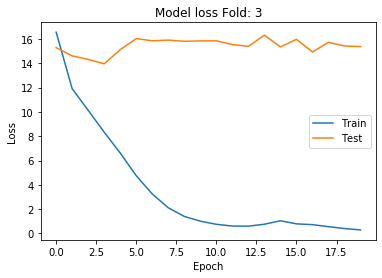

  Mean R^2    Std. R^2    Mean Corr.Coef.    Std. Corr.Coef.    Mean RMSE    Std. RMSE
----------  ----------  -----------------  -----------------  -----------  -----------
     0.248       0.066              0.562               0.02        4.052        0.071


In [6]:
print('Question 2.ii)')
print('')

print('b) Multilayer Perceptron')
print('')

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.utils import multi_gpu_model

A=[]
B=[]
C=[]

#Number of folds
kf=KFold(3, shuffle=True, random_state=0)
fold =0
    
for train, test in kf.split(image_ipca): 
    fold+=1
    image_ipca_train=image_ipca[train]
    Y_train=Y[train] 
    image_ipca_test=image_ipca[test]        
    Y_test=Y[test] 
        
    #Initialize the MLP
    model = Sequential()
    #Input and first hidden layer with size 200 neurons
    model.add(Dense(200, input_dim=image_ipca_train.shape[1],init='uniform',activation='relu'))
    model.add(Dense(200,init='uniform',activation='relu'))
    
    #Output layer full connected. We print the summary of the model
    model.add(Dense(1,init='uniform',activation='linear'))
    print(model.summary())
    
    #The model will be compiled and will use the MSE as loss function
    model.compile(loss = 'mse',optimizer='adam')
    
    #We generate the object that makes the fit of the model
    mlp_model=model.fit(image_ipca_train, Y_train,validation_split=0.2,nb_epoch = 20, batch_size = 50)
    
    #Calculation of the R^2, coef.corr and RMSE
    mlp_pred= model.predict(image_ipca_test)

    mlp_r2=metrics.r2_score(Y_test,mlp_pred)
    A.append(mlp_r2)

    mlp_corr=np.corrcoef(Y_test,mlp_pred,rowvar=False)[0,1]
    B.append(mlp_corr)

    mlp_rmse=np.sqrt(metrics.mean_squared_error(Y_test,mlp_pred))
    C.append(mlp_rmse)
    
    #Plot of the loss and validation loss given the epochs proposed
    plt.figure()
    plt.plot(mlp_model.history['loss'])
    plt.plot(mlp_model.history['val_loss'])
    plt.title('Model loss Fold: '+str(fold))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='center right')
    plt.show()
    
results=np.around([np.mean(A),np.std(A),np.mean(B),np.std(B),np.mean(C),np.std(C)],decimals=3)
table=[results]
print(tabulate(table, headers=["Mean R^2","Std. R^2","Mean Corr.Coef.","Std. Corr.Coef.","Mean RMSE","Std. RMSE"]))

In [7]:
print('Question 2.ii)')
print('')
print('c) Ridge Regression')

ridge = Ridge()

#Hyperparameter space
hyperparameters= {'alpha': [.001, .01,.5, 1,1.01,5,10],'fit_intercept':[True,False], 'normalize':[True,False],'copy_X':[True, False]}

clf = GridSearchCV(ridge, hyperparameters, cv=3, n_jobs=-1, verbose=0)
best_clf = clf.fit(image_ipca_train, Y_train.ravel())

#Optimal parameters
alpha=best_clf.best_estimator_.get_params()['alpha']
fit_intercept=best_clf.best_estimator_.get_params()['fit_intercept']
normalize=best_clf.best_estimator_.get_params()['normalize']
copy_X=best_clf.best_estimator_.get_params()['copy_X']

#Dictonary of all tuned hyperparameters
tune_hyper_lr=best_clf.best_params_
print('Best hyperparameters:')
print(tune_hyper_lr) 

#Optimal score given the optimal parameters
best_score=best_clf.best_score_
print('Best Score:')
print(best_score)   

def ridge_reg(alpha,fit_intercept,normalize,copy_X,image_ipca_train,Y_train):
    results=()
    #Number of folds
    skf = StratifiedKFold(n_splits=3,random_state=1,shuffle = True)
    A=[]
    B=np.empty([image_ipca_train.shape[1], 1])
    C=[]
      
    for i, (train_index, test_index) in enumerate(skf.split(image_ipca_train, Y_train)):
        Xcv_train, Xcv_test = image_ipca_train[train_index], image_ipca_train[test_index]
        Ycv_train, Ycv_test = Y_train[train_index], Y_train[test_index]
        
        #Hyperparameter object for ridge regression
        clf = Ridge(alpha=alpha,fit_intercept=fit_intercept,normalize=normalize)
        
        #Feature selection given the object of hyperparameters
        red_param=RFECV(clf, step=1, cv=3)
        
        #Training of the model given the best parameters
        red_param.fit(Xcv_train,Ycv_train.ravel())
        
        #Calculation of the predictions given the fitted model
        Y_pred=red_param.predict(Xcv_test)
        
        #Calculation of R^2, coef.corr and RMSE
        r2=r2_score(Ycv_test,Y_pred.ravel())
        A.append(r2)
                
        mse=np.sqrt(mean_squared_error(Ycv_test,Y_pred.ravel()))
        C.append(mse)
    
    #Calculation of all correlation coeficients for each PCA feature (200)
    for i in range(image_ipca_train.shape[1]):
        B[i,0]=np.corrcoef(image_ipca_train[:,i],Y_train,rowvar=False)[0,1]
        
    results=np.around([np.mean(A),np.std(A),np.mean(B),np.std(B),np.mean(C),np.std(C)],decimals=3)
    return(results)

results_ridge_reg=ridge_reg(alpha,fit_intercept,normalize,copy_X,image_ipca_train,Y_train)

table=[results_ridge_reg]
print('Ridge Regresion results:')
print(tabulate(table, headers=["Mean R^2","Std. R^2","Mean Corr.Coef.","Std. Corr.Coef.","Mean RMSE","Std. RMSE"]))
print('')
print('Summary of the table:')
print('Eventhough Ridge regression has a constrain as part of its model, it continues to be a linear model.')
print('Evidence suggest that a linear model is not suitable.')

Question 2.ii)

c) Ridge Regression
Best hyperparameters:
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'normalize': True}
Best Score:
0.21365440890183493


C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Ridge Regresion results:
  Mean R^2    Std. R^2    Mean Corr.Coef.    Std. Corr.Coef.    Mean RMSE    Std. RMSE
----------  ----------  -----------------  -----------------  -----------  -----------
     0.243       0.017              0.005              0.043        3.965        0.161

Summary of the table:
Eventhough Ridge regression has a constrain as part of its model, it continues to be a linear model.
Evidence suggest that a linear model is not suitable.


In [13]:
print('Question 2.ii)')
print('')
print('d) Support Vector Regression')

svr = SVR()

#Hyperparameter space
hyperparameters= {'kernel': ['rbf'],'degree':[1,2,3],'coef0':[0,.5],'C':[1,1.01],'epsilon':[0.5,1]}

clf = GridSearchCV(svr, hyperparameters, cv=3, n_jobs=-1, verbose=0)
best_clf = clf.fit(image_ipca_train, Y_train.ravel())

#Optimal parameters
kernel=best_clf.best_estimator_.get_params()['kernel']
degree=best_clf.best_estimator_.get_params()['degree']
coef0=best_clf.best_estimator_.get_params()['coef0']
C=best_clf.best_estimator_.get_params()['C']
epsilon=best_clf.best_estimator_.get_params()['epsilon']

#Dictonary of all tuned hyperparameters
tune_hyper_lr=best_clf.best_params_
print('Best hyperparameters:')
#{'C': 1, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'}

print(tune_hyper_lr) 

#Optimal score given the optimal parameters
best_score=best_clf.best_score_
print('Best Score:')
print(best_score)   

def svr_reg(image_ipca,Y):
    
    results=()
    #Number of folds
    skf = StratifiedKFold(n_splits=3,random_state=1,shuffle = True)
    A=[]
    B=[]
    C=[]
   
    for i, (train_index, test_index) in enumerate(skf.split(image_ipca, Y)):
        Xcv_train, Xcv_test = image_ipca[train_index], image_ipca[test_index]
        Ycv_train, Ycv_test = Y[train_index], Y[test_index]
        
        clf =SVR(kernel='rbf',degree=2,coef0=0.5,tol=.001,C=1,epsilon=0.5, shrinking=True,verbose=False)
        #Training of the model given the best parameters
        clf.fit(Xcv_train,Ycv_train)
        
        #Calculation of the predictions given the fitted model
        Y_pred=clf.predict(Xcv_test)
        
        #Calculation of R^2, coef.corr and RMSE
        r2=r2_score(Ycv_test,Y_pred.ravel())
        A.append(r2)
        
        corr=np.corrcoef(Ycv_test,Y_pred.ravel(),rowvar=False)[0,1]
        B.append(corr)
        
        mse=np.sqrt(mean_squared_error(Ycv_test,Y_pred.ravel()))
        C.append(mse)
                
    results=[np.mean(A),np.std(A),np.mean(B),np.std(B),np.mean(C),np.std(C)]
    return(results)

results_svr_reg=svr_reg(image_ipca,Y)

table=[results_svr_reg]
print(tabulate(table, headers=["Mean R^2","Std. R^2","Mean Corr.Coef.","Std. Corr.Coef.","Mean RMSE","Std. RMSE"]))

Question 2.ii)

d) Support Vector Regression
Best hyperparameters:
{'C': 1, 'coef0': 0, 'degree': 1, 'epsilon': 0.5, 'kernel': 'rbf'}
Best Score:
0.32643944061524566


C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

  Mean R^2    Std. R^2    Mean Corr.Coef.    Std. Corr.Coef.    Mean RMSE    Std. RMSE
----------  ----------  -----------------  -----------------  -----------  -----------
   0.40347  0.00733148           0.639024         0.00415365       3.6246    0.0751365


In [6]:
print('Question 3)')
print('')

import numpy as np
import pandas as pd
import h5py
import random
import csv 
from tabulate import tabulate
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,r2_score,matthews_corrcoef
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,precision_recall_curve, average_precision_score
from keras import layers
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.tensorflow_backend._get_available_gpus()
K.set_image_data_format('channels_last')
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import imshow
from skimage.color import rgb2hed
from joblib import Parallel, delayed
import multiprocessing
import concurrent.futures
import time

Question 3)



Using TensorFlow backend.


Question 3)



Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 283, 283, 16)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 141, 141, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 141, 141, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)       

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:106: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4936 samples, validate on 2468 samples
Epoch 1/20
4936/4936 [==============================] - 12s 2ms/step - loss: 22.6403 - mse: 22.6403 - val_loss: 26.3278 - val_mse: 26.3278
Epoch 2/20
4936/4936 [==============================] - 8s 2ms/step - loss: 22.3700 - mse: 22.3700 - val_loss: 25.7834 - val_mse: 25.7834
Epoch 3/20
4936/4936 [==============================] - 8s 2ms/step - loss: 21.4853 - mse: 21.4853 - val_loss: 21.8315 - val_mse: 21.8315
Epoch 4/20
4936/4936 [==============================] - 8s 2ms/step - loss: 16.9722 - mse: 16.9722 - val_loss: 16.5393 - val_mse: 16.5393
Epoch 5/20
4936/4936 [==============================] - 8s 2ms/step - loss: 14.4801 - mse: 14.4801 - val_loss: 13.8114 - val_mse: 13.8114
Epoch 6/20
4936/4936 [==============================] - 8s 2ms/step - loss: 13.9908 - mse: 13.9908 - val_loss: 19.7695 - val_mse: 19.7695
Epoch 7/20
4936/4936 [==============================] - 8s 2ms/step - loss: 13.4597 - mse: 13.4597 - val_loss: 16.8782 - va

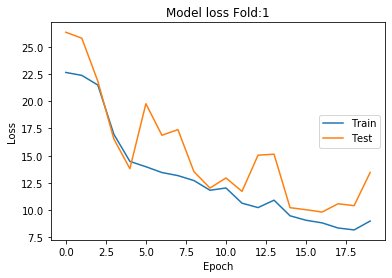

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 283, 283, 16)      80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 141, 141, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 141, 141, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)       

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:106: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4936 samples, validate on 2468 samples
Epoch 1/20
4936/4936 [==============================] - 9s 2ms/step - loss: 25.0970 - mse: 25.0970 - val_loss: 20.2217 - val_mse: 20.2217
Epoch 2/20
4936/4936 [==============================] - 8s 2ms/step - loss: 22.5809 - mse: 22.5809 - val_loss: 20.5529 - val_mse: 20.5529
Epoch 3/20
4936/4936 [==============================] - 9s 2ms/step - loss: 16.6878 - mse: 16.6878 - val_loss: 13.6756 - val_mse: 13.6756
Epoch 4/20
4936/4936 [==============================] - 9s 2ms/step - loss: 14.4035 - mse: 14.4035 - val_loss: 16.0506 - val_mse: 16.0506
Epoch 5/20
4936/4936 [==============================] - 9s 2ms/step - loss: 15.3174 - mse: 15.3174 - val_loss: 11.3091 - val_mse: 11.3091
Epoch 6/20
4936/4936 [==============================] - 8s 2ms/step - loss: 13.9431 - mse: 13.9431 - val_loss: 10.7609 - val_mse: 10.7609
Epoch 7/20
4936/4936 [==============================] - 8s 2ms/step - loss: 14.0463 - mse: 14.0463 - val_loss: 10.4403 - val

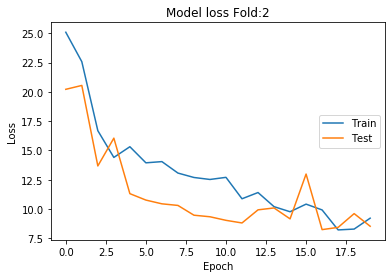

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 283, 283, 16)      80        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 141, 141, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 141, 141, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 64)       

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:106: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4936 samples, validate on 2468 samples
Epoch 1/20
4936/4936 [==============================] - 9s 2ms/step - loss: 22.2737 - mse: 22.2737 - val_loss: 26.1740 - val_mse: 26.1740
Epoch 2/20
4936/4936 [==============================] - 8s 2ms/step - loss: 20.9961 - mse: 20.9961 - val_loss: 22.7439 - val_mse: 22.7439
Epoch 3/20
4936/4936 [==============================] - 8s 2ms/step - loss: 15.3256 - mse: 15.3256 - val_loss: 14.6669 - val_mse: 14.6669
Epoch 4/20
4936/4936 [==============================] - 8s 2ms/step - loss: 14.0995 - mse: 14.0995 - val_loss: 16.2336 - val_mse: 16.2336
Epoch 5/20
4936/4936 [==============================] - 8s 2ms/step - loss: 13.0578 - mse: 13.0578 - val_loss: 13.4554 - val_mse: 13.4554
Epoch 6/20
4936/4936 [==============================] - 8s 2ms/step - loss: 13.1268 - mse: 13.1268 - val_loss: 13.0629 - val_mse: 13.0629
Epoch 7/20
4936/4936 [==============================] - 8s 2ms/step - loss: 12.1396 - mse: 12.1396 - val_loss: 12.7868 - val

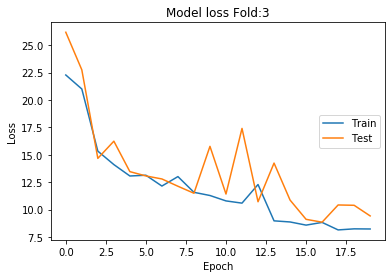

  Mean R^2    Std. R^2    Mean Corr.Coef.    Std. Corr.Coef.    Mean RMSE    Std. RMSE
----------  ----------  -----------------  -----------------  -----------  -----------
     0.525       0.078              0.769              0.014        3.219        0.324


In [1]:
#Path of the folder that I am going to use
filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/breast.h5"

D = h5py.File(filepath, 'r')
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

P.shape=[P.shape[0],1]
Y.shape=[Y.shape[0],1]

filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/"
   
#Call the h5 file from the folder that is saved
datasets_ipca = h5py.File(filepath+str('datasets_ipca.h5'), 'r')

images_channel_D=datasets_ipca.get('images_channel_D')
images_channel_D= np.array(images_channel_D)
images_channel_D=np.expand_dims(images_channel_D, axis=3)
images_channel_D.shape

#Number of folds
kf=KFold(3, shuffle=True, random_state=0)
A=[]
B=[]
C=[]

fold =0
for train, test in kf.split(images_channel_D): 
    fold+=1
    images_channel_D_train=images_channel_D[train]
    Y_train=Y[train] 
    images_channel_D_test=images_channel_D[test]
    Y_test=Y[test] 
    
    #Initialize the CNN
    model = Sequential()
    
    #Input the shape of the initial layer and then make the first convolution with maxpooling. All activation functions are ReLu
    model.add(Conv2D(16, (2, 2), padding='same',input_shape=(283,283,1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Second convolution with maxpooling and we add dropout
    model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    #Third convolution with maxpooling and we add dropout
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    #Fourth convolution with maxpooling and we add dropout
    model.add(Conv2D(128, (5, 5), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    #Fifth convolution with maxpooling and we add dropout
    model.add(Conv2D(64, (5, 5), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(0.25))
    
    #Flatten of the space and then a full connected layer with linear activation function
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    
    model.add(Dense(units=1, activation='linear'))
    
    #The model will be compiled and will use the MSE as loss function. We also print a summary of the model
    model.compile(optimizer='adam',loss = 'mse',metrics=['mse'])
    print(model.summary())
    
    #We generate the object that makes the fit of the model
    CNN_model=model.fit(images_channel_D_train,Y_train.ravel(),validation_data=(images_channel_D_test,Y_test.ravel()),nb_epoch = 20, batch_size = 50)

    #We generate the predictions of the fitted model
    CNN_pred= model.predict(images_channel_D_test)
    
    #Plot of the loss and validation loss given the epochs proposed
    plt.figure()
    plt.plot(CNN_model.history['loss'])
    plt.plot(CNN_model.history['val_loss'])
    plt.title('Model loss Fold:'+str(fold))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='center right')
    plt.show()
    
    #Calculation of R^2, coef.corr and RMSE
    CNN_r2=metrics.r2_score(Y_test,CNN_pred)
    A.append(CNN_r2)

    CNN_corr=np.corrcoef(Y_test,CNN_pred,rowvar=False)[0,1]
    B.append(CNN_corr)
    
    CNN_rmse=np.sqrt(metrics.mean_squared_error(Y_test,CNN_pred))
    C.append(CNN_rmse)
    
results=np.around([np.mean(A),np.std(A),np.mean(B),np.std(B),np.mean(C),np.std(C)],decimals=3)
table=[results]
print(tabulate(table, headers=["Mean R^2","Std. R^2","Mean Corr.Coef.","Std. Corr.Coef.","Mean RMSE","Std. RMSE"]))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 283, 283, 16)      80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 141, 141, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 141, 141, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)       

C:\Users\juanvarl\anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py:50: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 5841 samples, validate on 1563 samples
Epoch 1/20
5841/5841 [==============================] - 9s 2ms/step - loss: 22.1810 - mse: 22.1810 - val_loss: 30.1021 - val_mse: 30.1021
Epoch 2/20
5841/5841 [==============================] - 9s 2ms/step - loss: 21.1046 - mse: 21.1046 - val_loss: 26.7978 - val_mse: 26.7978
Epoch 3/20
5841/5841 [==============================] - 9s 2ms/step - loss: 20.8800 - mse: 20.8800 - val_loss: 26.3467 - val_mse: 26.3467
Epoch 4/20
5841/5841 [==============================] - 9s 2ms/step - loss: 20.8980 - mse: 20.8980 - val_loss: 26.4791 - val_mse: 26.4791
Epoch 5/20
5841/5841 [==============================] - 9s 2ms/step - loss: 21.0082 - mse: 21.0082 - val_loss: 26.4992 - val_mse: 26.4992
Epoch 6/20
5841/5841 [==============================] - 9s 2ms/step - loss: 21.0016 - mse: 21.0016 - val_loss: 26.6090 - val_mse: 26.6090
Epoch 7/20
5841/5841 [==============================] - 9s 2ms/step - loss: 18.4858 - mse: 18.4858 - val_loss: 18.6146 - val

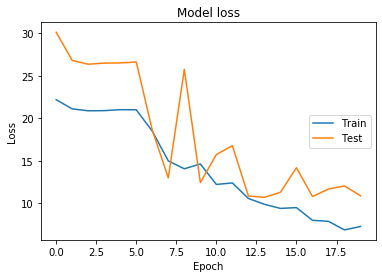

CNN R^2: 0.5846212491420245
CNN RMSE: 3.301672411827546
CNN Coef.Corr: 0.7899270981708945


Text(0, 0.5, 'Y Test')

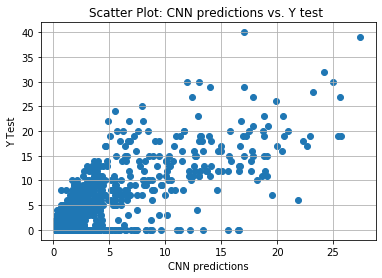

In [8]:
filepath = "C:/Users/juanvarl/Documents/Maestria/Materias/Term_2/CS909_Data Mining/Assignment/Assignment_2_JVL/"
   
#Call the h5 file from the folder that is saved
datasets_ipca = h5py.File(filepath+str('datasets_ipca.h5'), 'r')

images_channel_D=datasets_ipca.get('images_channel_D')
images_channel_D = np.array(images_channel_D)
images_channel_D=np.expand_dims(images_channel_D, axis=3)
images_channel_D.shape

idtrain=[i for i, P in enumerate(P) if P <=13]
idtest=[i for i, P in enumerate(P) if P >13]

images_channel_D_train=images_channel_D[idtrain]
images_channel_D_test=images_channel_D[idtest]
Y_train=Y[idtrain] 
Y_train=np.reshape(Y_train,(Y_train.shape[0],1))
Y_test=Y[idtest] 
Y_test=np.reshape(Y_test,(Y_test.shape[0],1))

#Initialize the CNN
model = Sequential()

#Input the shape of the initial layer and then make the first convolution with maxpooling. All activation functions are ReLu
model.add(Conv2D(16, (2, 2), padding='same',input_shape=(283,283,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Second convolution with maxpooling and we add dropout
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#Third convolution with maxpooling and we add dropout
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#Fourth convolution with maxpooling and we add dropout
model.add(Conv2D(128, (5, 5), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#Fifth convolution with maxpooling and we add dropout
model.add(Conv2D(64, (5, 5), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.25))

#Flatten of the space and then a full connected layer with linear activation function
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam',loss = 'mse',metrics=['mse'])
print(model.summary())

CNN_model=model.fit(images_channel_D_train,Y_train.ravel(),validation_data=(images_channel_D_test,Y_test.ravel()),nb_epoch = 20, batch_size = 50)

#We generate the predictions of the fitted model
CNN_pred= model.predict(images_channel_D_test)

#Plot of the loss and validation loss given the epochs proposed
plt.plot(CNN_model.history['loss'])
plt.plot(CNN_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

#Calculation of R^2, coef.corr and RMSE
CNN_r2=metrics.r2_score(Y_test,CNN_pred)
CNN_rmse=np.sqrt(metrics.mean_squared_error(Y_test,CNN_pred))
CNN_corr=np.corrcoef(Y_test,CNN_pred,rowvar=False)[0,1]

print('CNN R^2:', CNN_r2)
print('CNN RMSE:', CNN_rmse)
print('CNN Coef.Corr:', CNN_corr)

#Scatter plot of the predictions against the real cell count
plt.scatter(CNN_pred,Y_test);plt.grid();plt.title('Scatter Plot: CNN predictions vs. Y test ');plt.xlabel('CNN predictions');plt.ylabel('Y Test')

### In contrast with all the results obtained, the CNN gives the best result with a R^2= 0.58. Even though in the last layer of the CNN we have a linear activation function, we have through all the network ReLu functions, making our model non-linear. Other structures were used to fit the model, but this one gave the best result. By trial and error, twenty epochs was optimal not to overfit and underfit the model. 

### As further investigations, it will be interesting to repeat the model without the images that have, less or equal than two cell count and see how the model behaves. The fact that we do not have the same amount of images per patient bias our model. This model has a bigger R^2 than the CV model because we are using more data as our training set.